Let's consider a simple instance, Burgers Equation:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=\nu\frac{\partial^2u}{\partial x^2}$$

$$x\in[-1,1],\quad t\in[0,1]$$

with the Dirichlet boundary conditions and initial conditions

$$u(-1,t)=u(1,t)=0,\quad u(x,0)=-\sin(\pi x).$$

Step 1: Setup

In [48]:
import sys
sys.path.append('H:/毕业论文/pykan')
sys.path.append('H:/毕业论文/efficient-kan/src')
from efficient_kan import KAN as EKAN
# import deepxde as dde
import torch
torch.set_default_dtype(torch.float64)
import torch.nn as nn
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from kan import KAN, LBFGS
# from kan import LBFGS
import numpy as np
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def batch_jacobian(func, x, create_graph=False):
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

def batch_hessian(func, x):
    jacobian = batch_jacobian(func, x, create_graph=True)
    hessians = []
    for i in range(jacobian.size(1)):
        grad = autograd.grad(jacobian[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessians.append(grad.unsqueeze(1))
    return torch.cat(hessians, dim=1)

Using device: cuda:0


Step 2:

In this Part, according to the problem, we need to construct the specific PDE.

In [49]:
#geom 物理区域
geom = [-1.0,1.0]
num_points_x = 128  #网格的大小

#时间区域  For time-independent PDE, we don't need this.
TimeDomain = [0,1.0]
num_points_t = 50

# geomtime = dde.geometry.GeometryXTime(dde.geometry.Interval(geom[0],geom[1]),dde.geometry.TimeDomain(TimeDomain[0],TimeDomain[1]))

#网格化
x = torch.linspace(geom[0], geom[1], 
                   steps=num_points_x, device=device,
                   requires_grad=False)

t = torch.linspace(TimeDomain[0],TimeDomain[1],
                   steps=num_points_t, device=device,
                   requires_grad=False)

X,T = torch.meshgrid(x, t, indexing='ij')
coordinates = torch.stack([X.flatten(), T.flatten()], dim = 1).to(device)
print(coordinates.shape)
coordinates.requires_grad = True  # Ensure coordinates require grad 确保coordinates需要梯度
##
##这一步的目的是生成一个二维网格，将空间和时间域内的离散点组合成所有可能的坐标对，
##从而用于进一步的计算或模型训练。这种方法常用于物理学、工程学和机器学习中的数值模拟和求解偏微分方程（PDEs）

torch.Size([6400, 2])


Step 3: KAN

In [50]:
#注意到我们其实需要的是一个 两个输入x和t 一个输出真解u 的KAN神经网络
layer = [2] + [3]*2 + [1]   #[input] + [nn]*hiden + [output] 

# #oringinal KAN
# model = KAN(width=layer, grid=3, k=3, grid_eps=1,
#             noise_scale_base=0.25,device = device)

#efficient - KAN
model = EKAN(layer,grid_size=4,spline_order=4,scale_noise=0.25,grid_eps=1.0,base_activation=nn.Identity).to(device)

由于边界条件：

$$u(-1,t)=u(1,t)=0,~~~~~ \mathrm{MSE_{BC}}(u_{pred},0)$$

由于初始条件：

$$\quad u(x,0)=-\sin(\pi x), ~~~~~\mathrm{MSE_{IC}}(u_{pred}, -\sin(\pi x))$$



In [51]:
def pde(coords):
    #前置定义过程
    coords = coords.clone().detach().requires_grad_(True)  # Ensure coords require grad
    grads = batch_jacobian(model , coords, create_graph= True)  #计算Jacobian矩阵 batch_jacobian(fun, variable, creat_graph = True)
    hessians = batch_hessian(model, coords)

    #PDE的定义过程： 
    u = model(coords)  #predicted solution
    
    #coords[X,T]  [:, :, :]  前两个指的的真解u 后一个指的是对应的x和t x：0  t：1
    u_t = grads[:,0,1]  #d_u/dt
    # print("u_t: ",u_t,u_t.shape)
    u_x = grads[:,0,0]  #d_u/dx
    # print("u_x: ",u_x,u_x.shape)
    u_xx = hessians[:,0, 0]  #d^2_u/dx^2

    #residuals of PDE：PDE的残差
    equation = u_t + u * u_x - 0.01 / np.pi * u_xx
    pde_loss = torch.mean(equation ** 2)

    # bc_loss = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    # ic_loss = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

    # BC and IC: 找到位于边界和初始上的点
    BC_mask = (coords[:, 0] == geom[0]) | (coords[:, 0] == geom[1])
    IC_mask = (coords[:, 1] == TimeDomain[0])
    
    BC_points = coords[BC_mask][:,0].unsqueeze(1)
    IC_points = coords[IC_mask][:,0].unsqueeze(1)

    # print("IC_X:",IC_points,IC_points.shape)

    # print("BC_POINT",coords[BC_mask],coords[BC_mask].shape)
    # print("IC_POINT",coords[IC_mask],coords[IC_mask].shape)

    ##BC:边界条件
    model_bc = model(coords[BC_mask])  #coords[BC_mask][X:T] X:-1.0 and 1.0  T:uniform[0,1]  [200 x 2]
    bc_loss = torch.mean(model_bc**2)

    ##IC:初始条件
    model_ic = model(coords[IC_mask])  #coords[IC_mask][X:T] X:uniform[-,1]  T:0  [200 x 2]
    true_ic = torch.sin(np.pi * IC_points)
    ic_loss = torch.mean((model_ic + true_ic)**2)  #Only ic need a minus-form
    #print("BC:", bc_loss)
    #print("IC:", ic_loss)
    #print("PDE:", pde_loss)
    total_loss = pde_loss + ic_loss + bc_loss
    
    return total_loss

In [52]:
Loss = []
l2_losses = []
writer = SummaryWriter()

def train():
    optimizer = LBFGS(model.parameters(), lr=1e-1,
                      history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    # optimizer = optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
    
    steps = 30 # 20 steps are enough
    pbar = tqdm(range(steps), desc='Training Progress')

    for step in pbar:
        def closure():
            optimizer.zero_grad()
            loss = pde(coordinates)
            loss.backward()
            return loss

        optimizer.step(closure)
        if step % 2 == 0:
            current_loss = closure().item()
            pbar.set_description("Step: %d | Loss: %.3f" %
                                 (step, current_loss))
            writer.add_scalar('Loss/train', current_loss, step)
        Loss.append(closure().item())
        # l2_losses.append(l2.detach().numpy())
        # print("Current Loss: ",Loss[step])

train()
writer.close()
print(Loss)
plt.plot(Loss, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['Total loss'])
plt.title('Loss of KAN') 

Step: 16 | Loss: 0.190:  60%|██████    | 18/30 [01:12<00:48,  4.05s/it]


KeyboardInterrupt: 

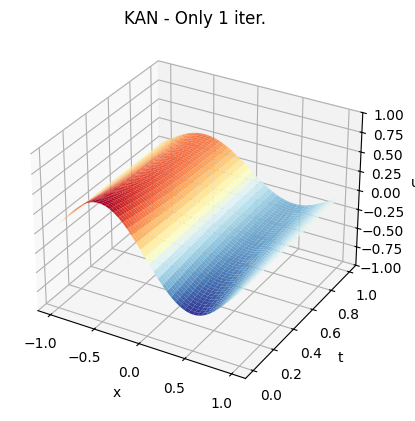

In [ ]:
#画图
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
import matplotlib.pyplot as plt

t = np.linspace(0,1,100)
x = np.linspace(-1,1,256)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)
pt_x = torch.from_numpy(x).double().requires_grad_(True).to(device)
pt_t = torch.from_numpy(t).double().requires_grad_(True).to(device)
pt_u0 = model(torch.cat([pt_x,pt_t],1))
u = pt_u0.data.cpu().numpy()

pt_u0=u.reshape(100,256)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlim([-1, 1])
ax.plot_surface(ms_x, ms_t, pt_u0, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.title('KAN - Only 1 iter.') 
plt.savefig('KAN.png')
plt.show(fig)

In [ ]:
# model.plot(beta=10)